This notebook contains detection experiments for MNIST and CIFAR10 datasets.

In [1]:
import torch
import detection
import numpy as np
import argparse
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
import seaborn as sns
sns.set_style("whitegrid")
from typing import Dict, Any

In [2]:
model = "mnist"  # cifar10 (and rn34), mnist
if model == "cifar10":
    ground_path = "attacker_cifar_to_cifar_ws250_base_ground_truth.pkl"
    watermark_path = "attacker_cifar_to_cifar_ws250_base_watermark.pkl"
    legitimate_path = "victim_cifar_base_ground_truth.pkl"
elif model == "cifar10rn34":
    ground_path = "attacker_cifar_to_cifar_ws250_rn34_ground_truth.pkl"
    watermark_path = "attacker_cifar_to_cifar_ws250_rn34_watermark.pkl"
    legitimate_path = "victim_cifar_rn34_ground_truth.pkl"
elif model == "mnist":
    ground_path = "attacker_mnist_to_mnist_ws250_l5_ground_truth.pkl"
    watermark_path = "attacker_mnist_to_mnist_ws250_l5_watermark.pkl"
    legitimate_path = "victim_mnist_l5_ground_truth.pkl"
else:
    raise Exception("Mistakes were made.")

batched = True

root = "data/detection/"

In [3]:
watermark = detection.load_file(root + watermark_path)
ground = detection.load_file(root + ground_path)
legitimate = detection.load_file(root + legitimate_path)

if batched:
    ground = [img for batch in ground for img in batch]
    watermark = [img for batch in watermark for img in batch]
    legitimate = [img for batch in legitimate for img in batch]

In [4]:
print("Ground: {}".format(len(ground)))
print("Watermark: {}".format(len(watermark)))
print("Legitimate: {}".format(len(legitimate)))

Ground: 60000
Watermark: 250
Legitimate: 59999


In [5]:
def bin_into_classes(list_of_batched_logits, msg):
    logits_np = defaultdict(list)
    for logit in list_of_batched_logits:
        as_np = logit.cpu().detach().numpy().squeeze()
        logits_np[np.argmax(as_np)].append(as_np)

    grouped = defaultdict(list)
    for k in logits_np.keys():
        grouped[k] = np.vstack(logits_np[k])

    print(msg)
    for k, v in grouped.items():
        print(k, v.shape)
        
    return grouped

In [6]:
ground_grouped = bin_into_classes(ground, "Total class distribution.")
watermark_grouped = bin_into_classes(watermark, "Watermark class distribution.")
legitimate_grouped = bin_into_classes(legitimate, "Legitimate class distribution.")

Total class distribution.
9 (5938, 10)
2 (5955, 10)
1 (6752, 10)
8 (5858, 10)
3 (6141, 10)
5 (5417, 10)
4 (5842, 10)
6 (5911, 10)
0 (5930, 10)
7 (6256, 10)
Watermark class distribution.
1 (35, 10)
0 (26, 10)
4 (21, 10)
3 (37, 10)
2 (21, 10)
8 (28, 10)
9 (19, 10)
6 (22, 10)
7 (23, 10)
5 (18, 10)
Legitimate class distribution.
2 (5958, 10)
1 (6742, 10)
0 (5923, 10)
8 (5851, 10)
5 (5421, 10)
4 (5842, 10)
9 (5949, 10)
6 (5917, 10)
7 (6265, 10)
3 (6131, 10)


In [7]:
def scale_pca_cluster(ground_logit, watermark_logit, method="ICA", components=3):
    if method == "ICA":
        projection = decomposition.FastICA(n_components=components, max_iter=5000)
    else:
        projection = decomposition.PCA(n_components=components)
        
    fun = pipeline.make_pipeline(preprocessing.StandardScaler(), projection)
    ground_transformed = fun.fit_transform(ground_logit)
    
    kmeans = cluster.KMeans(n_clusters=2)
    ypred = kmeans.fit_predict(ground_transformed)
    watermark_transformed = fun.transform(watermark_logit) if len(watermark_logit) > 0 else None
    ypred_wm = kmeans.predict(watermark_transformed) if len(watermark_logit) > 0 else None
    
    return ground_transformed, watermark_transformed, ypred, ypred_wm, metrics.silhouette_score(ground_transformed, ypred)

In [8]:
def plot(class_, ground_transformed, watermark_transformed, ypred, ypred_wm, silhouette_score):
    fontsize = 18
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)

    first = ax1.scatter(
        ground_transformed[:, 0],
        ground_transformed[:, 1],
        c=ground_transformed[:, 2],
        marker="o", label="Legitimate", alpha=0.5)

    if watermark_transformed is not None:
        second = ax1.scatter(
            watermark_transformed[:, 0],
            watermark_transformed[:, 1],
            c=watermark_transformed[:, 2],
            marker="x", label="Watermark", s=400)

    ax1.figure.colorbar(first, ax=ax1).set_label(label="Third component", size=fontsize)

    ax1.set_xlabel("First component", fontsize=fontsize)
    ax1.set_ylabel("Second component", fontsize=fontsize)
    ax1.set_title("Ground truth", fontsize=fontsize)
    for label, m in zip([0, 1], ["o", "^"]):
        ax2.scatter(
            ground_transformed[ypred == label, 0],
            ground_transformed[ypred == label, 1],
            c=ground_transformed[ypred == label, 2],
            marker=m)

    ax2.figure.colorbar(first, ax=ax2).set_label(label="Third component", size=fontsize)

    ax2.set_xlabel("First component", fontsize=fontsize)
    ax2.set_ylabel("Second component", fontsize=fontsize)
    ax2.set_title("Clustering labels", fontsize=fontsize)

    DPI = fig.get_dpi()
    fig.set_size_inches(1200.0 / float(DPI), 600.0 / float(DPI))

    plt.suptitle(
        f"Class: {class_} " + 
        f"Total: {len(ground_transformed)} " +
        f"with WM: {len(watermark_transformed) if watermark_transformed is not None else 0}" +
        f"\nSilh Score: {silhouette_score:0.2f}", fontsize=fontsize)

    return [(np.sum(ypred == 0), np.sum(ypred == 1))], np.sum(ypred_wm == 0), np.sum(ypred_wm == 1)

def min_max(a, idx):
    return np.min(a[:, idx]), np.max(a[:, idx])

In [9]:
def plot3d(class_, ground_transformed, watermark_transformed, ypred, silhouette_score):
    fontsize = 18
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax1 = fig.add_subplot(121, projection="3d")
    ax2 = fig.add_subplot(122, projection="3d")
    
    first = ax1.scatter(
        ground_transformed[:, 0],
        ground_transformed[:, 1],
        ground_transformed[:, 2],
        c="b",
        marker="o", label="Legitimate", alpha=0.5)

    min_x, max_x = min_max(ground_transformed, 0)
    min_y, max_y = min_max(ground_transformed, 1)
    min_z, max_z = min_max(ground_transformed, 2)
    
    ax1.set_xlim([min_x, max_x])
    ax1.set_ylim([min_y, max_y])
    ax1.set_zlim([min_z, max_z])
    
    def ticks(min_, max_):
        diff = max_ - min_
        step = diff / 4
        return [min_ + step, min_ + step * 2, min_ + step * 3]
    
    ticks_x = ticks(min_x, max_x)
    ticks_y = ticks(min_y, max_y)
    ticks_z = ticks(min_z, max_z)
    ax1.set_xticks(ticks_x)
    ax1.set_yticks(ticks_y)
    ax1.set_zticks(ticks_z)
    
    def tick_labels(ticks_):
        return [f"{tick:0.3f}" for tick in ticks_]
    
    ax1.w_xaxis.set_ticklabels(tick_labels(ticks_x), fontsize=fontsize)
    ax1.w_yaxis.set_ticklabels(tick_labels(ticks_y), fontsize=fontsize)
    ax1.w_zaxis.set_ticklabels(tick_labels(ticks_z), fontsize=fontsize) 
    
    if watermark_transformed is not None:
        second = ax1.scatter(
            watermark_transformed[:, 0],
            watermark_transformed[:, 1],
            watermark_transformed[:, 2],
            c="r",
            marker="x", label="Watermark", s=400)
    
    ax1.set_title("Ground truth", fontsize=fontsize)
    for label, m, colour in zip([0, 1], ["o", "^"], ["b", "g"]):
        ax2.scatter(
            ground_transformed[ypred == label, 0],
            ground_transformed[ypred == label, 1],
            ground_transformed[ypred == label, 2],
            c=colour,
            marker=m)

    ax2.set_title("Clustering labels", fontsize=fontsize)

    ax2.set_xlim([min_x, max_x])
    ax2.set_ylim([min_y, max_y])
    ax2.set_zlim([min_z, max_z])

    ax2.set_xticks(ticks_x)
    ax2.set_yticks(ticks_y)
    ax2.set_zticks(ticks_z)
    
    ax2.w_xaxis.set_ticklabels(tick_labels(ticks_x), fontsize=fontsize)
    ax2.w_yaxis.set_ticklabels(tick_labels(ticks_y), fontsize=fontsize)
    ax2.w_zaxis.set_ticklabels(tick_labels(ticks_z), fontsize=fontsize)
    
    _ = fig.subplots_adjust(wspace=0.0001)
    DPI = fig.get_dpi()
    fig.set_size_inches(1200.0 / float(DPI), 600.0 / float(DPI))
    
    plt.suptitle(
        f"Class: {class_} " + 
        f"Total: {len(ground_transformed)} " +
        f"with WM: {len(watermark_transformed) if watermark_transformed is not None else 0}" +
        f"\nSilh Score: {silhouette_score:0.2f}", fontsize=fontsize)
    
#     plt.savefig(f"paper/figs/detection-{model}-{class_}.pdf")
    plt.show()

In [10]:
def analyze(ground_grouped, watermark_grouped):
    sizes = []
    silhouettes = []
    wms_in_a = []
    wms_in_b = []
    for class_ in ground_grouped.keys():
        k = int(class_)

        ground_transformed, watermark_transformed, ypred, ypred_wm, silhouette_score = \
            scale_pca_cluster(ground_grouped[k], watermark_grouped[k])

        szs, wm_in_a, wm_in_b = plot(k, ground_transformed, watermark_transformed, ypred, ypred_wm, silhouette_score)
        sizes += szs
        wms_in_a.append(wm_in_a)
        wms_in_b.append(wm_in_b)
        silhouettes.append(silhouette_score)
        plot3d(k, ground_transformed, watermark_transformed, ypred, silhouette_score)

    sum_of_smaller = 0
    sum_of_wm_in_smaller = 0
    sum_of_wm_in_larger = 0
    ratio = []
    for (a, b), wm_in_a, wm_in_b in zip(sizes, wms_in_a, wms_in_b):
        smaller = min(a, b)
        sum_of_smaller += smaller
        sum_of_wm_in_smaller += wm_in_a if a < b else wm_in_b
        sum_of_wm_in_larger += wm_in_a if a > b else wm_in_b
        ratio.append(smaller / (a + b))
        
    ratio = np.asarray(ratio)
    silhouettes = np.asarray(silhouettes)
    
    print(
        f"Ratio of smaller to (smaller + larger): mu = {np.mean(ratio)}, sigma = {np.std(ratio)}" +
        f"\nSilhouettes: mu = {np.mean(silhouettes)}, sigma = {np.std(silhouettes)}" +
        f"\nRatio of smaller in total: {sum_of_smaller / len(ground)}" +
        f"\nActual WM ratio: {250 / len(ground)}" +
        f"\nWM in smaller: {sum_of_wm_in_smaller}\nWM in larger: {sum_of_wm_in_larger}")

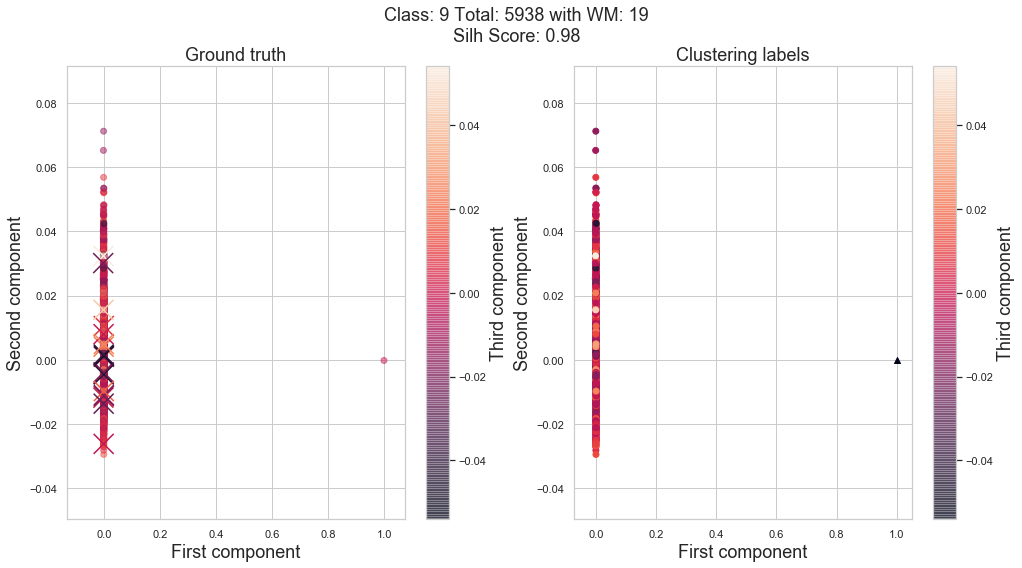

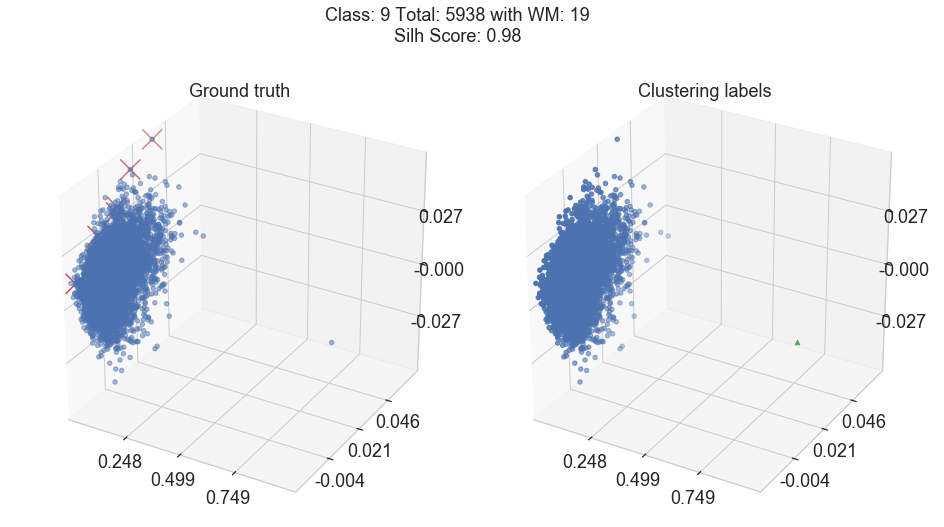

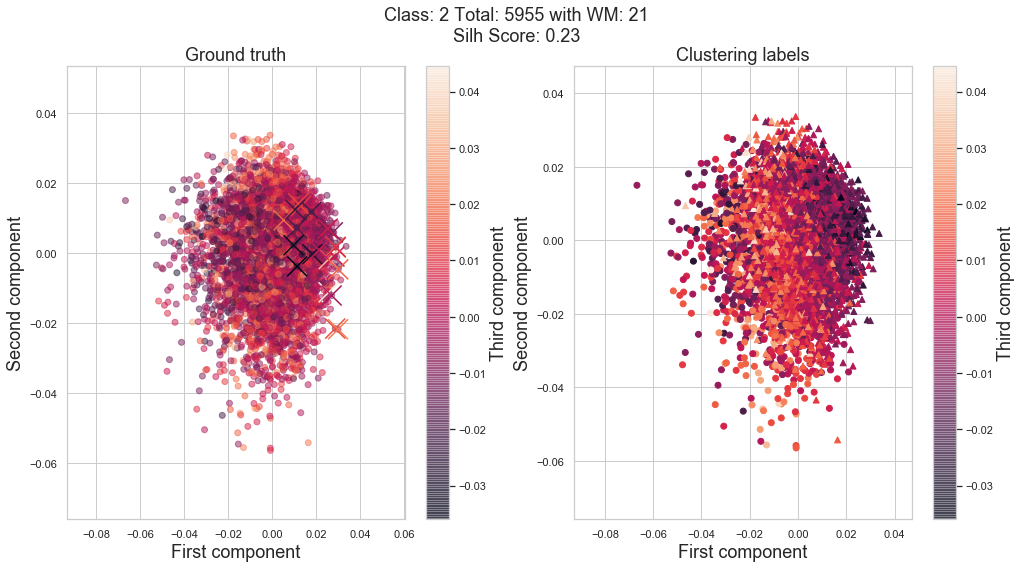

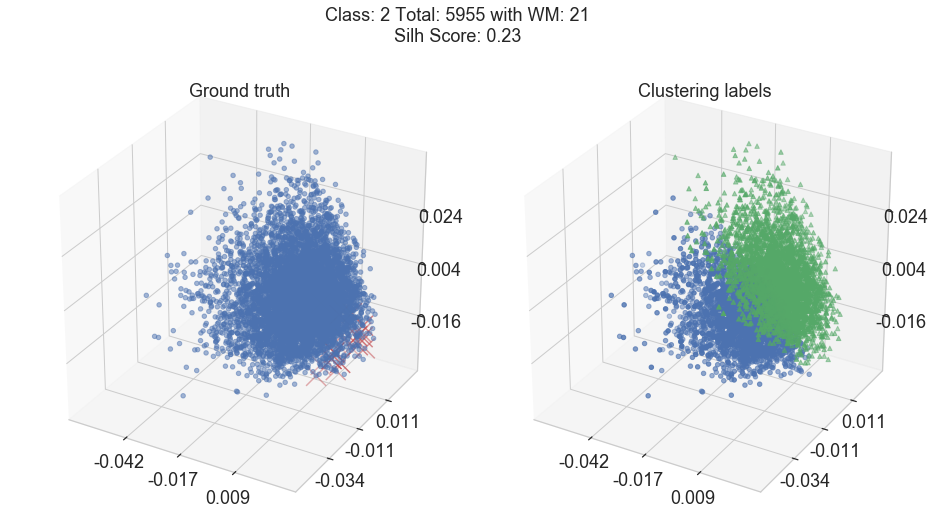

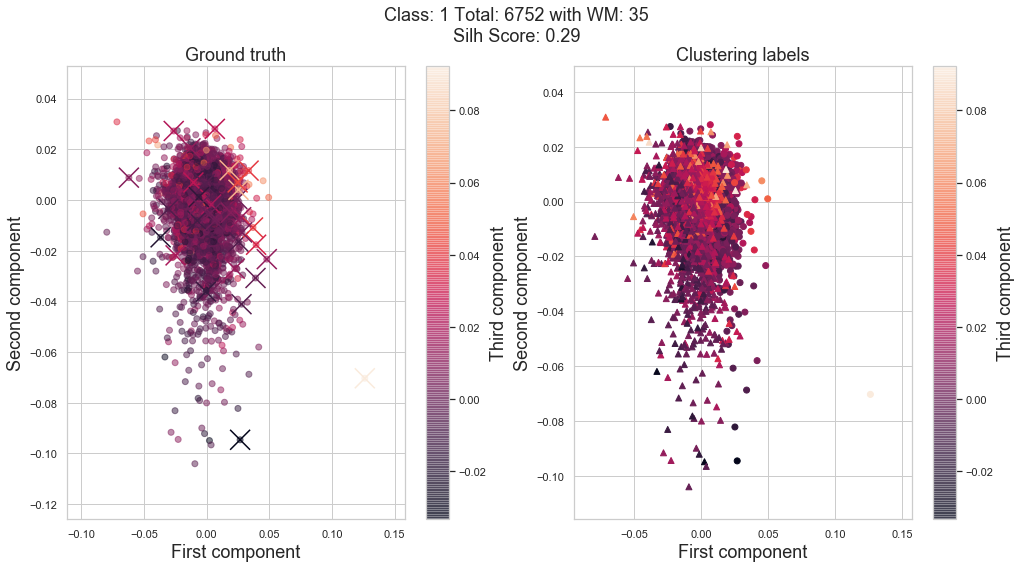

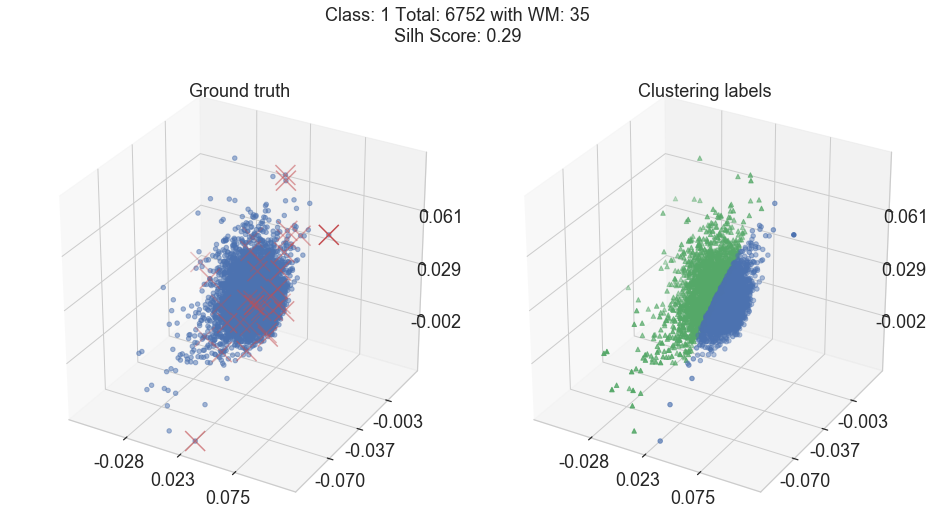

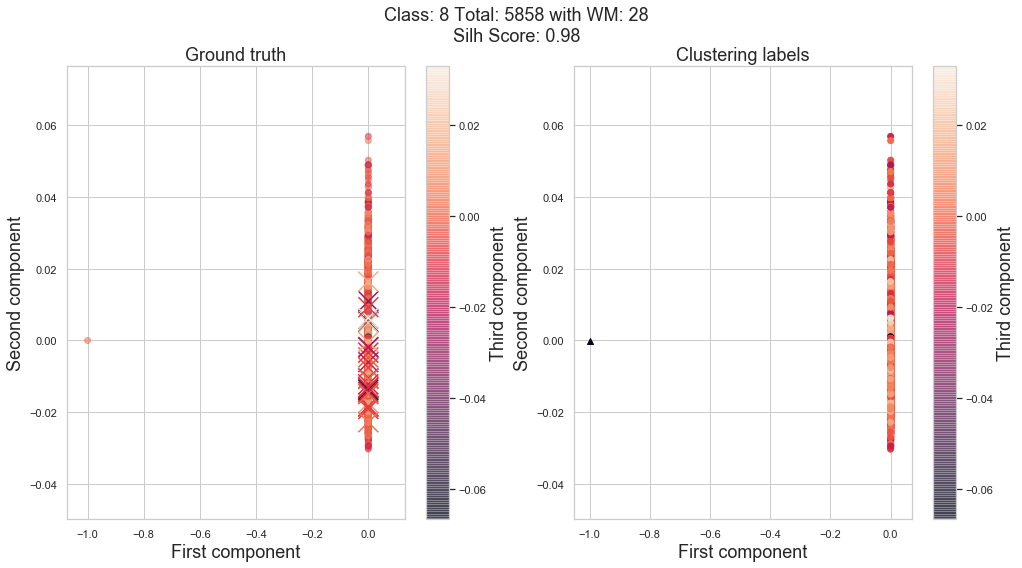

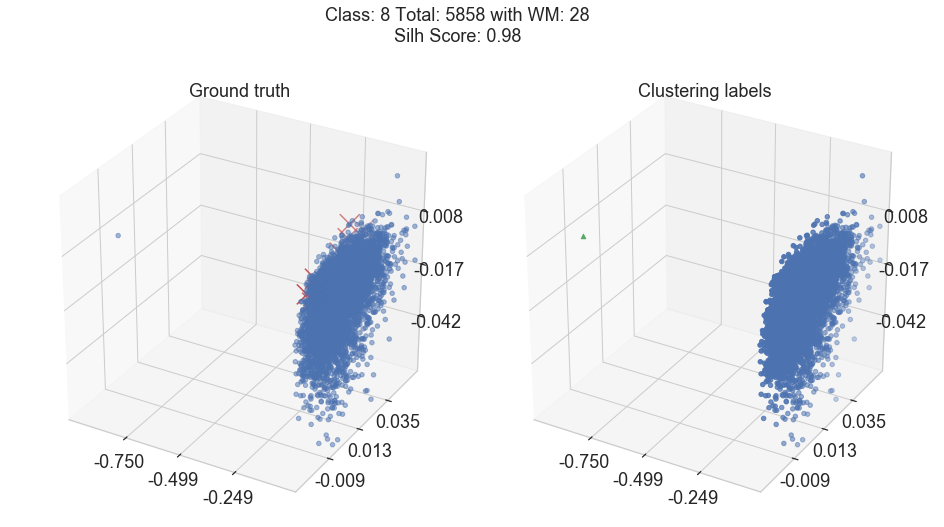

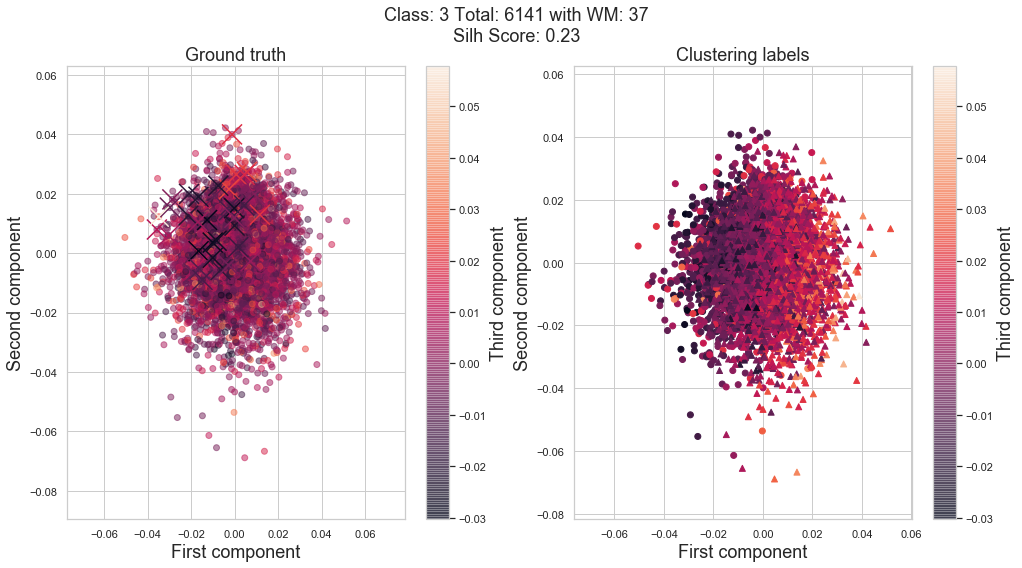

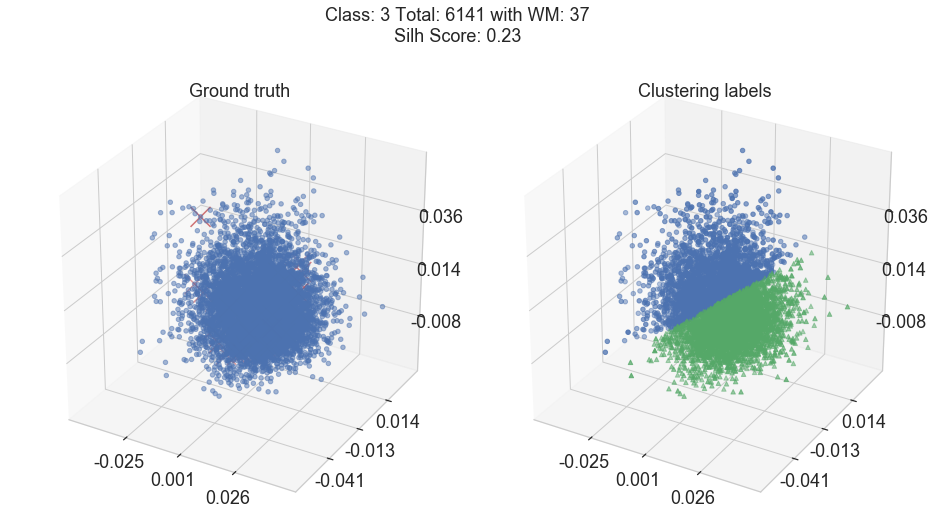

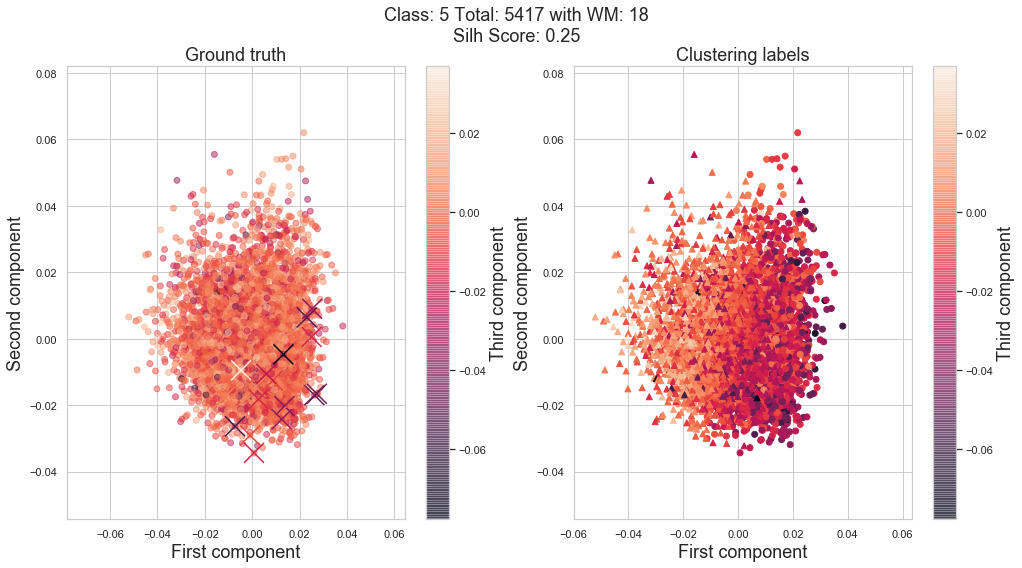

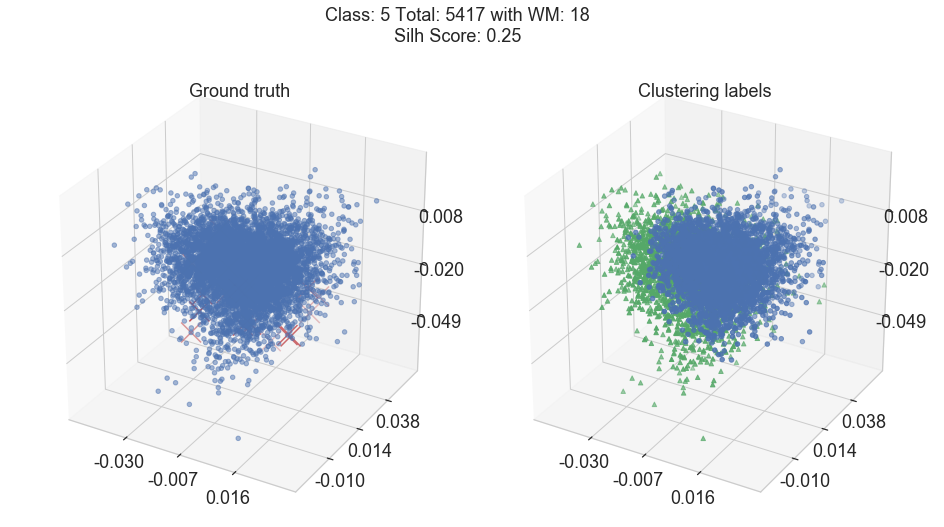

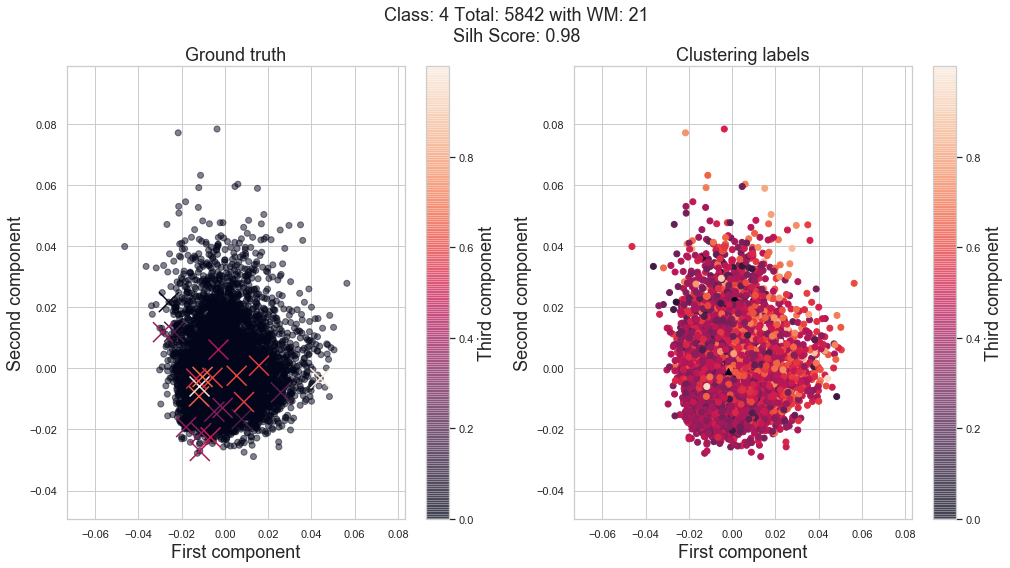

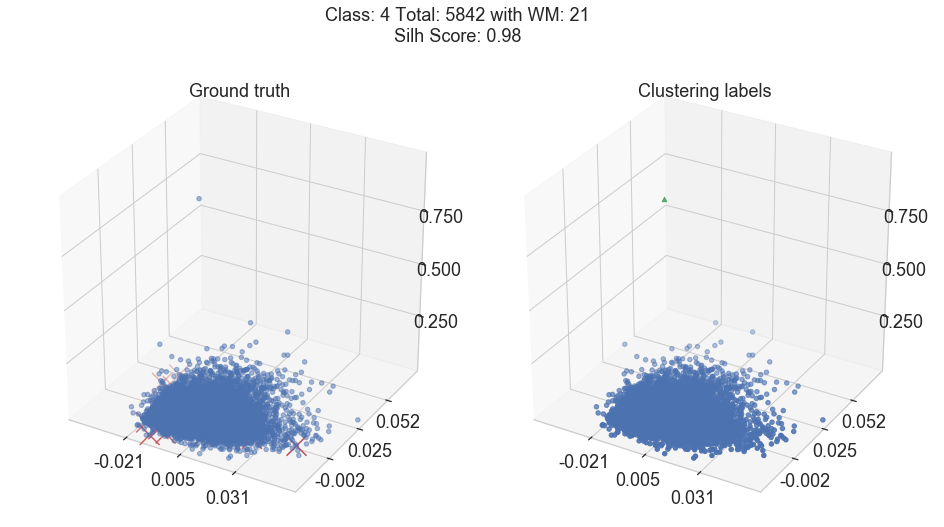

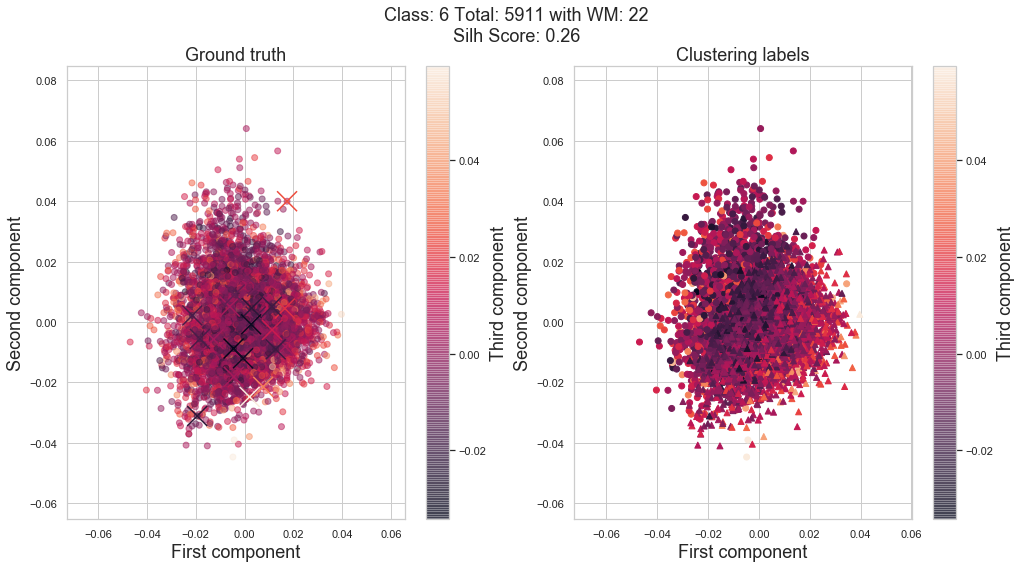

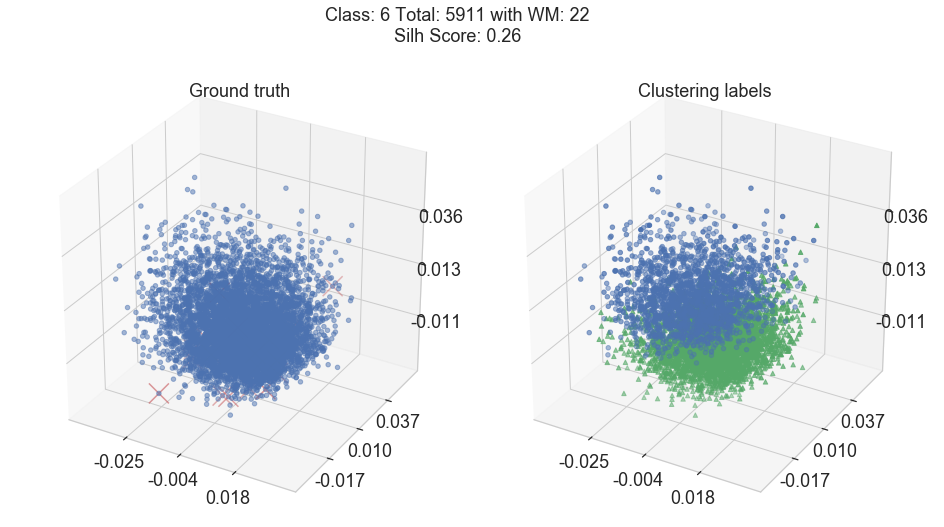

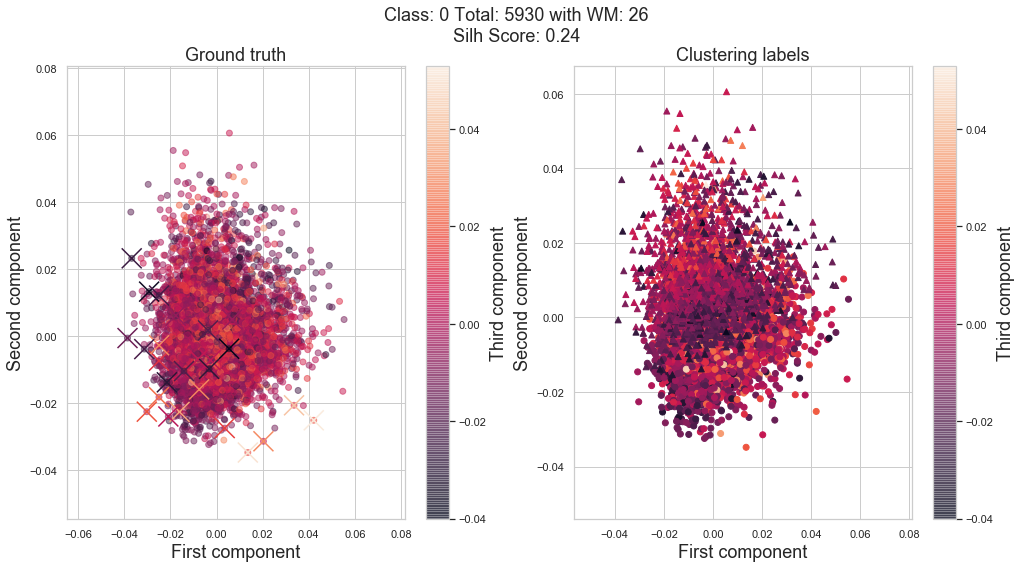

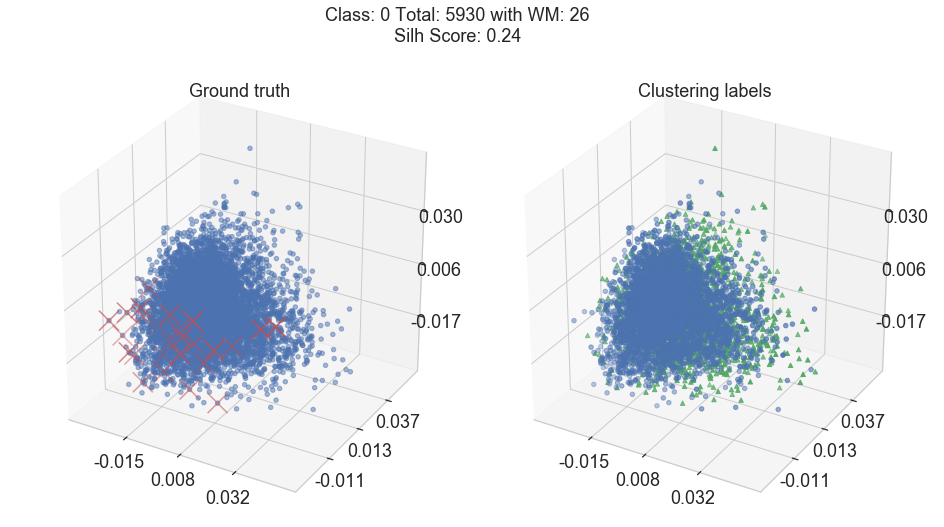

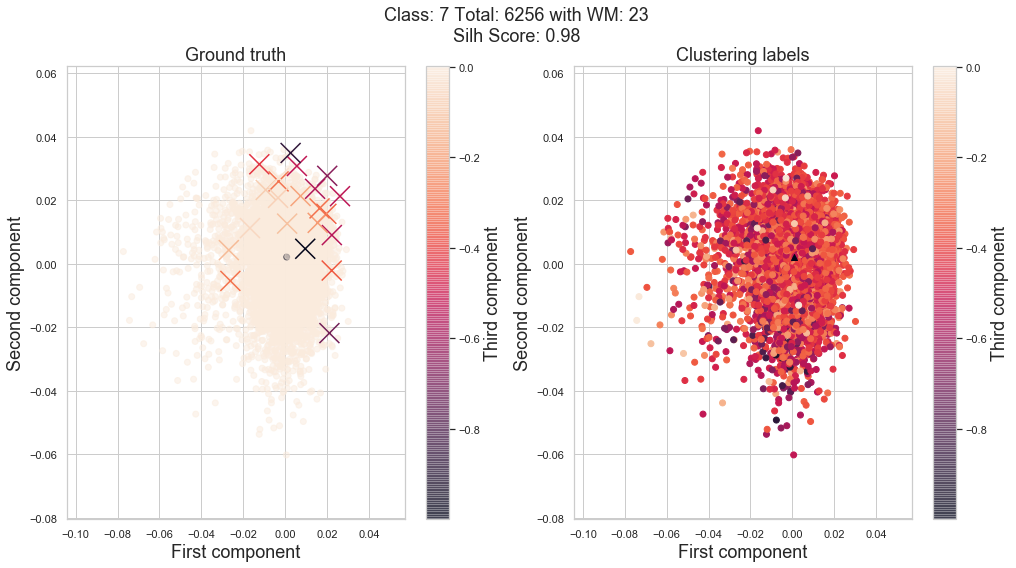

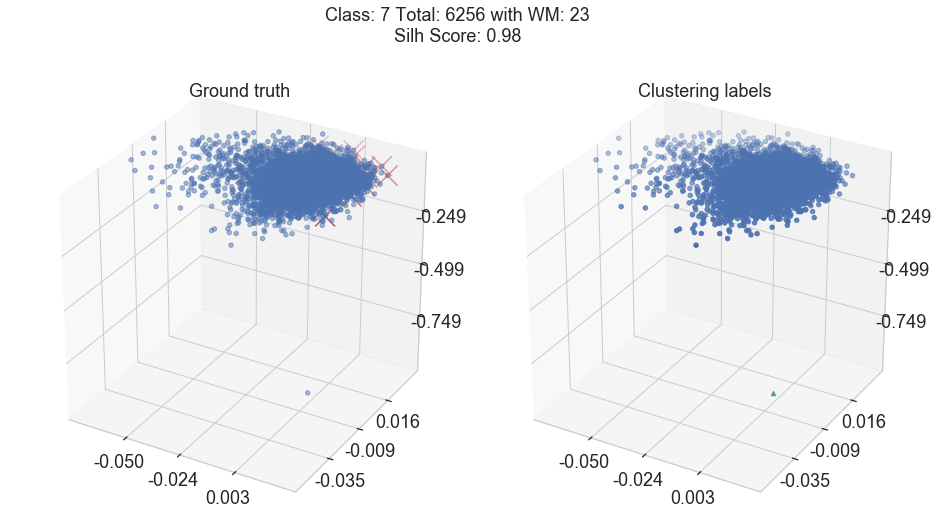

Ratio of smaller to (smaller + larger): mu = 0.2242351817721219, sigma = 0.18469883104435067
Silhouettes: mu = 0.5403221129227931, sigma = 0.3572235831537646
Ratio of smaller in total: 0.2246
Actual WM ratio: 0.004166666666666667
WM in smaller: 46
WM in larger: 204


In [11]:
analyze(ground_grouped, watermark_grouped)

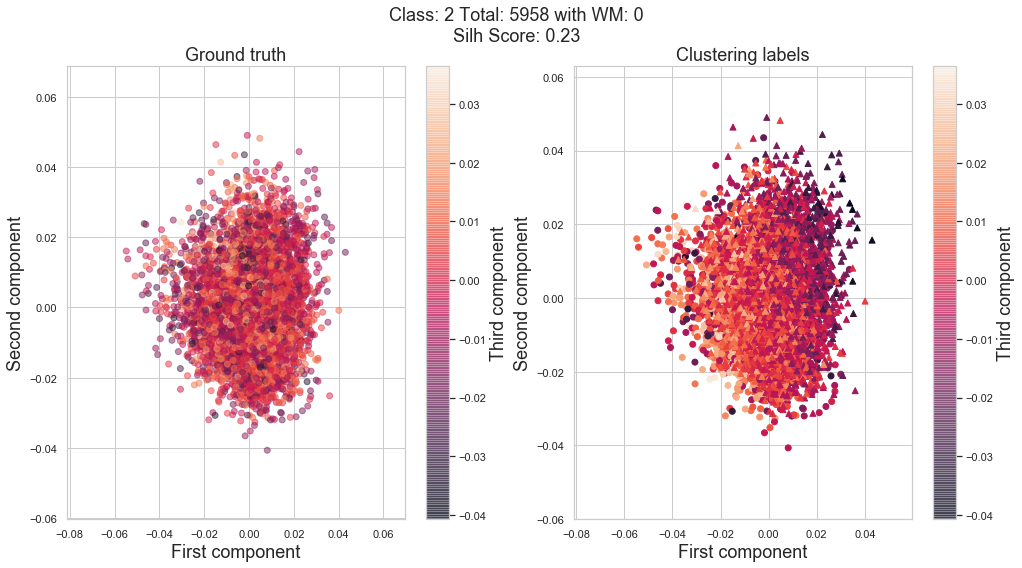

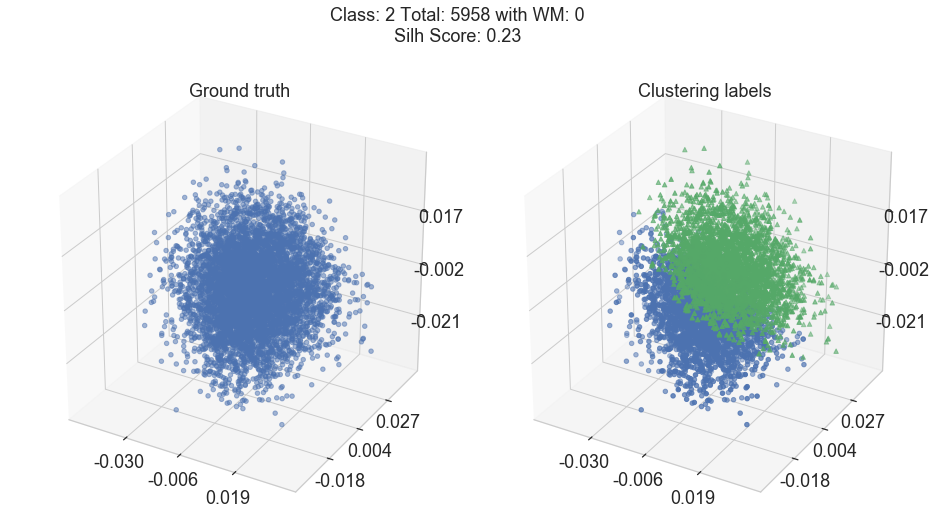

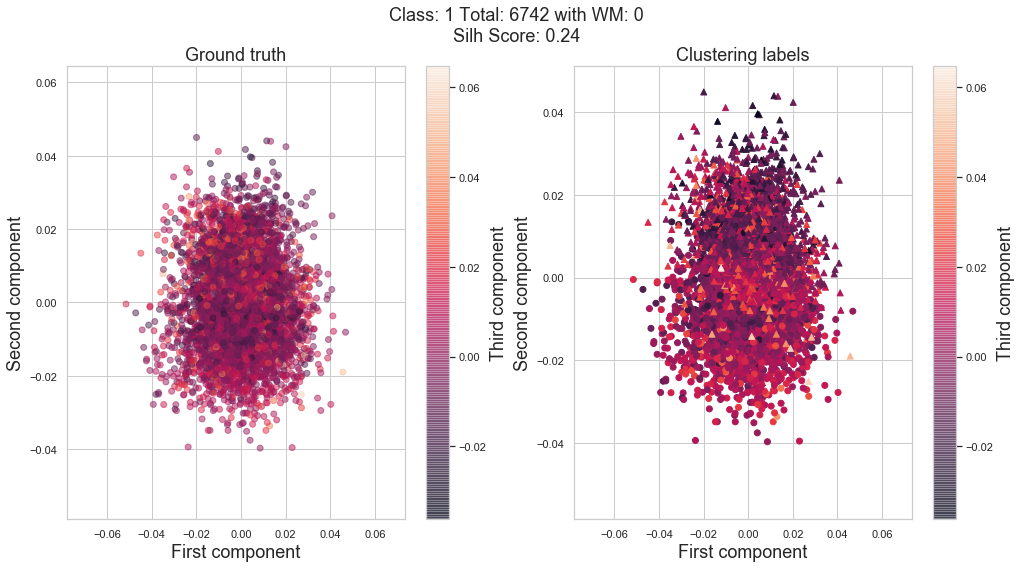

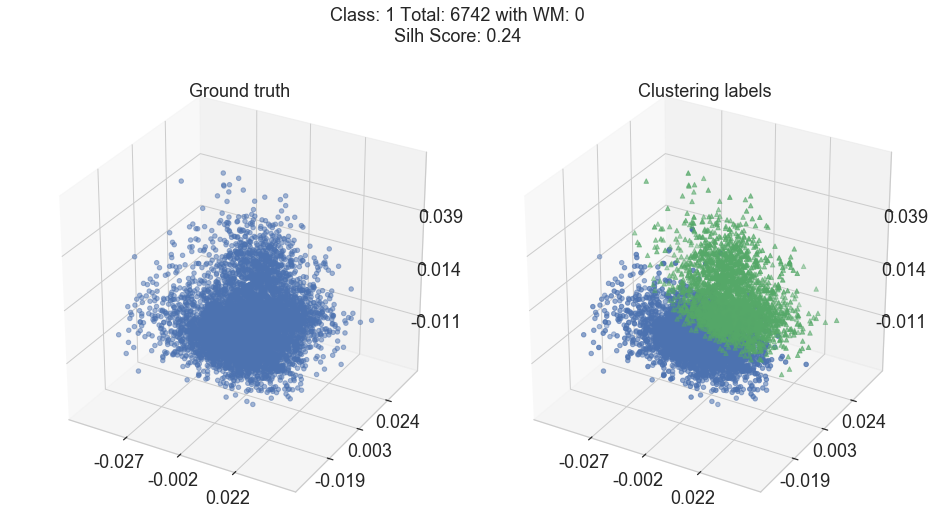

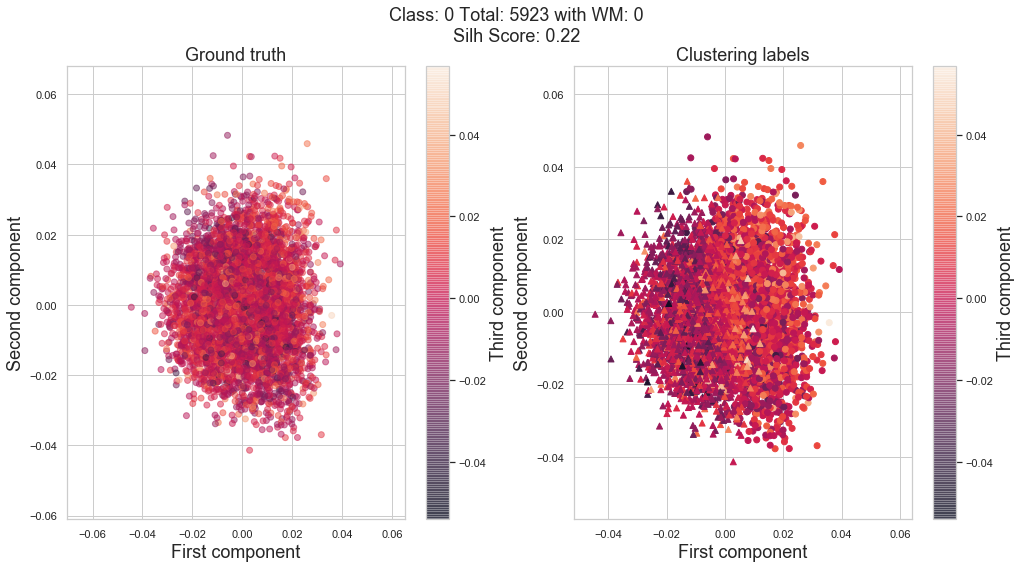

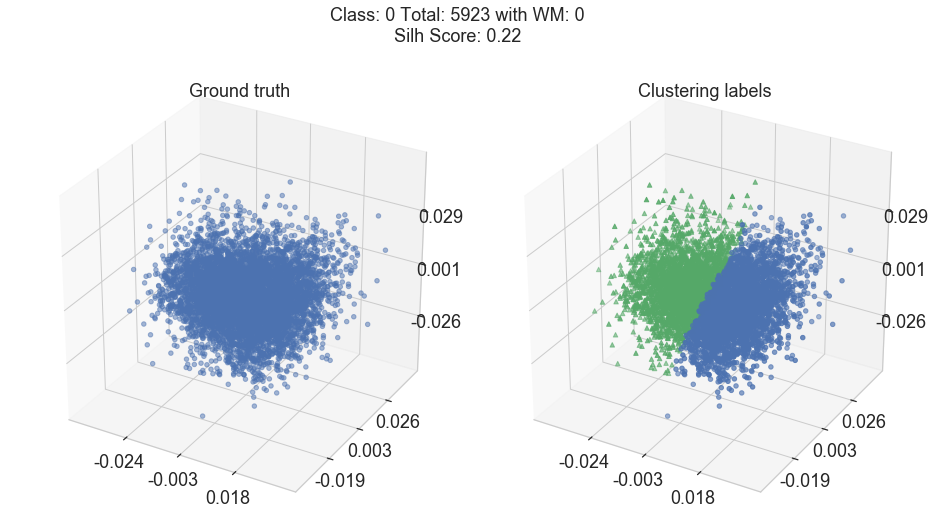

/u/56/szylles1/unix/.conda/envs/dawn/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/u/56/szylles1/unix/.conda/envs/dawn/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


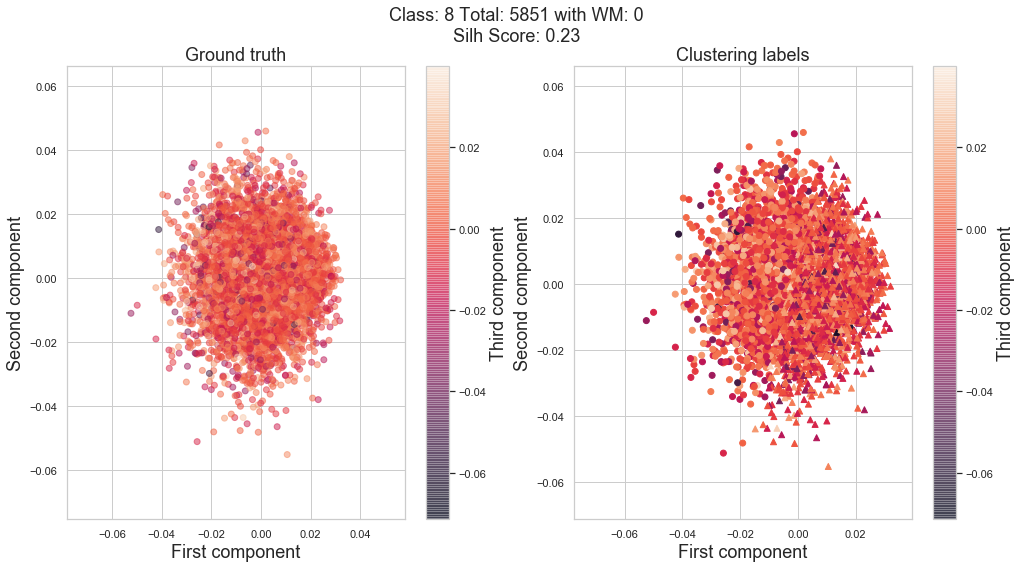

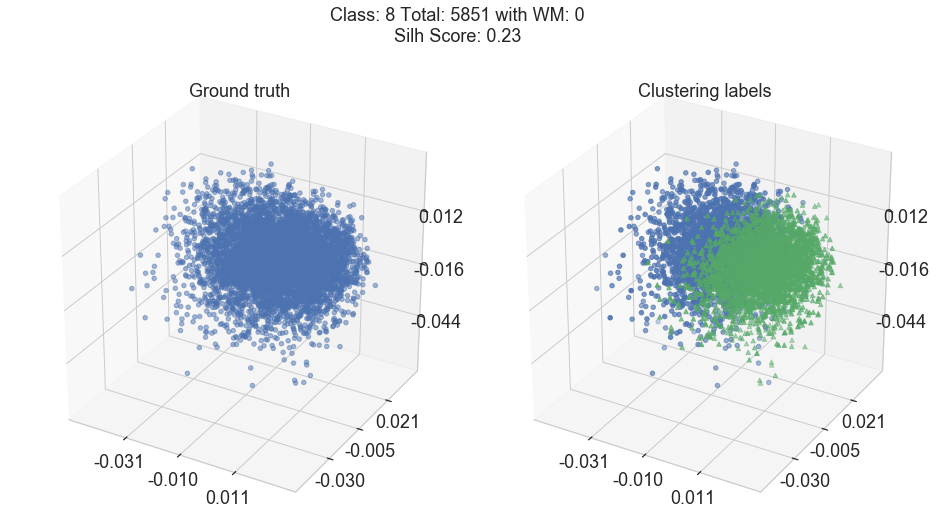

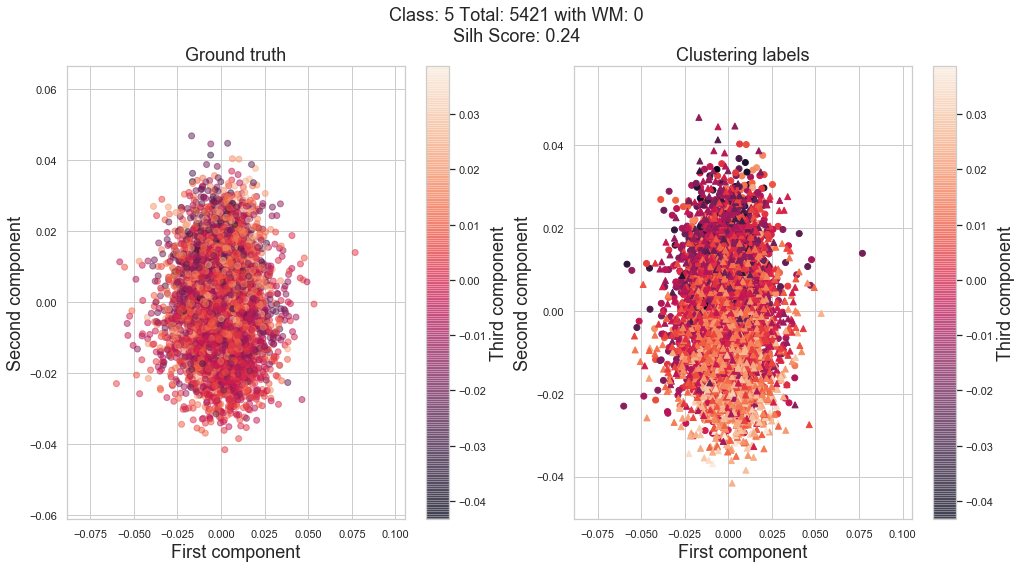

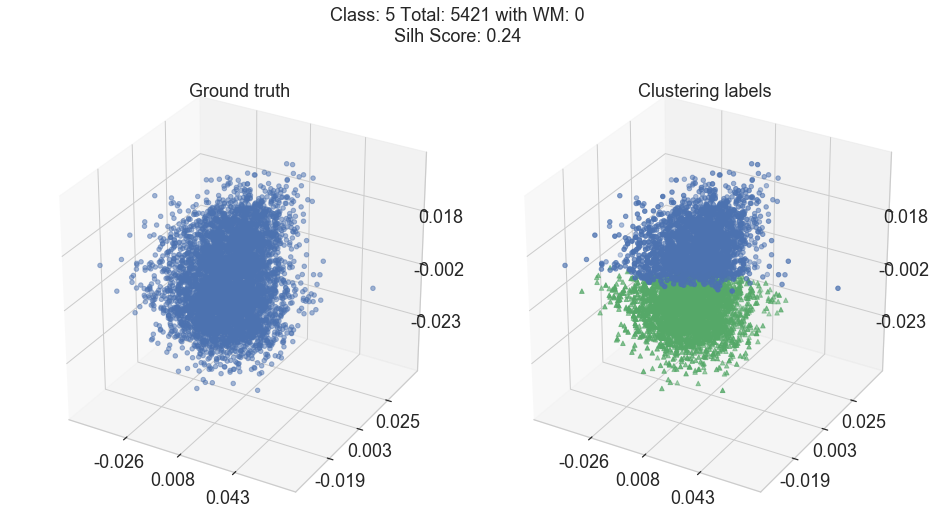

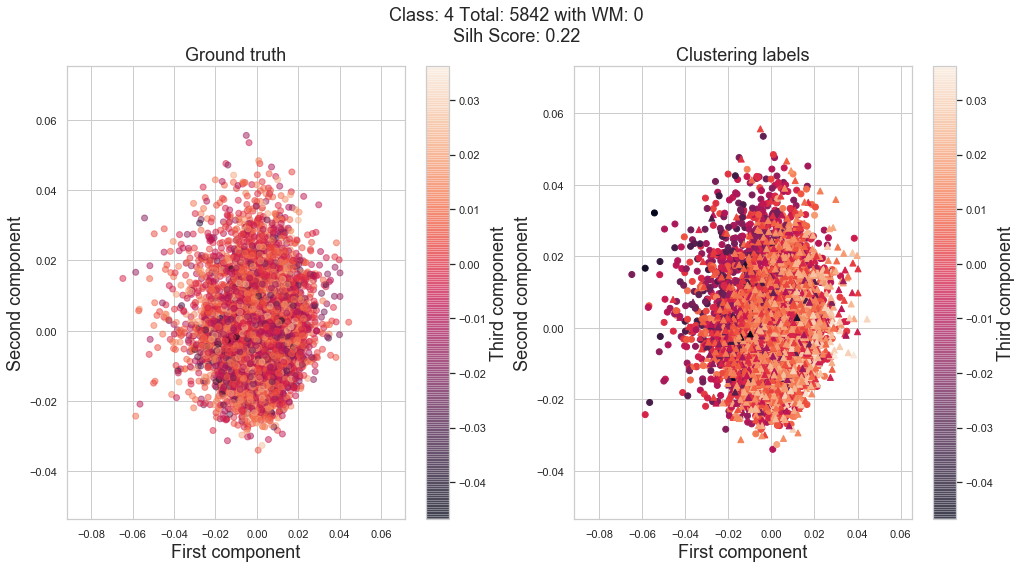

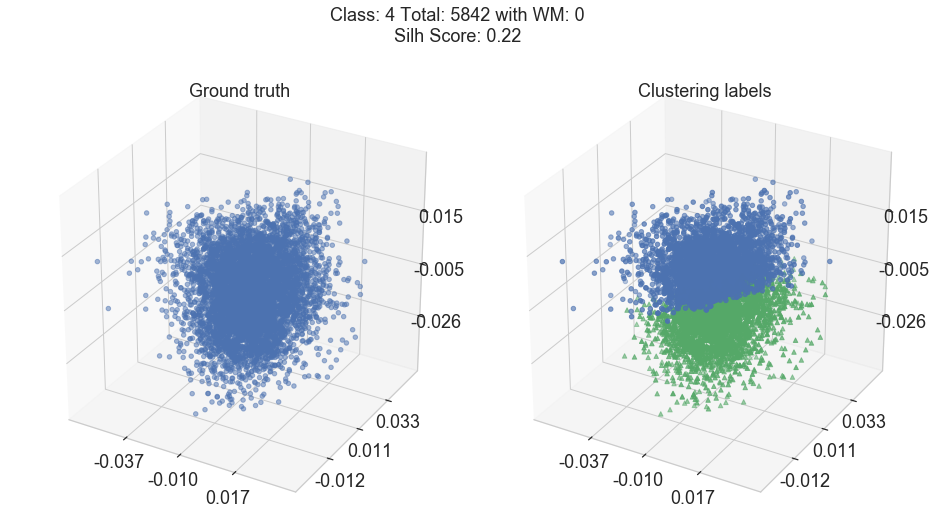

/u/56/szylles1/unix/.conda/envs/dawn/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: divide by zero encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140
/u/56/szylles1/unix/.conda/envs/dawn/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:316: RuntimeWarning: invalid value encountered in true_divide
  K = (u / d).T[:n_components]  # see (6.33) p.140


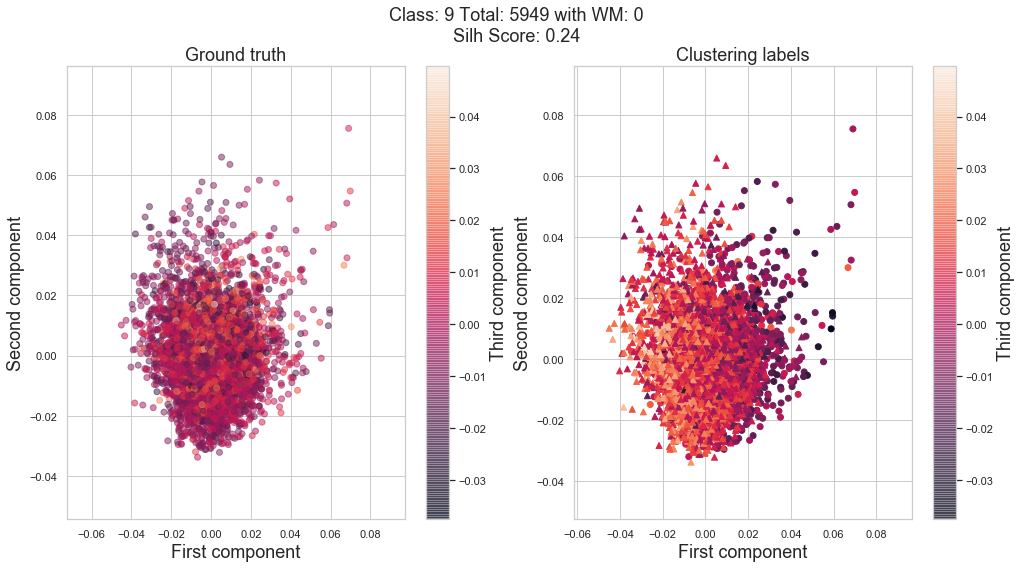

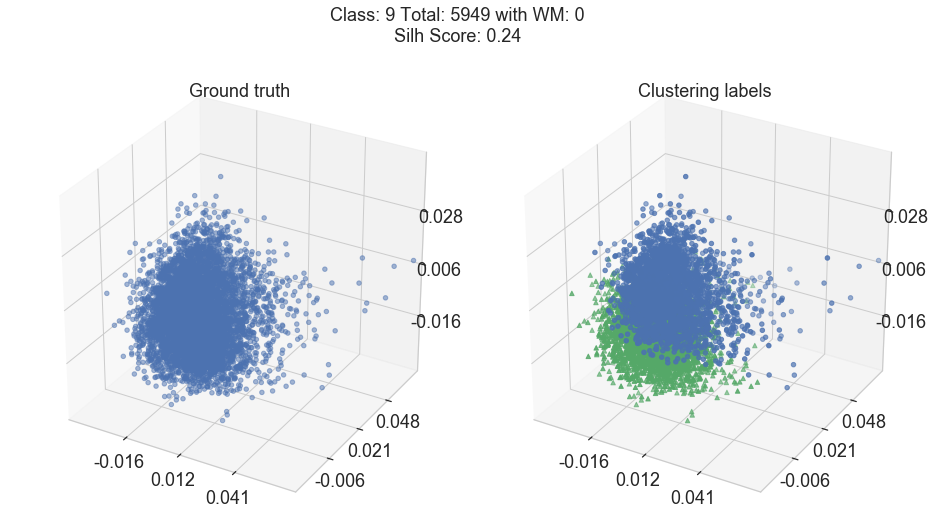

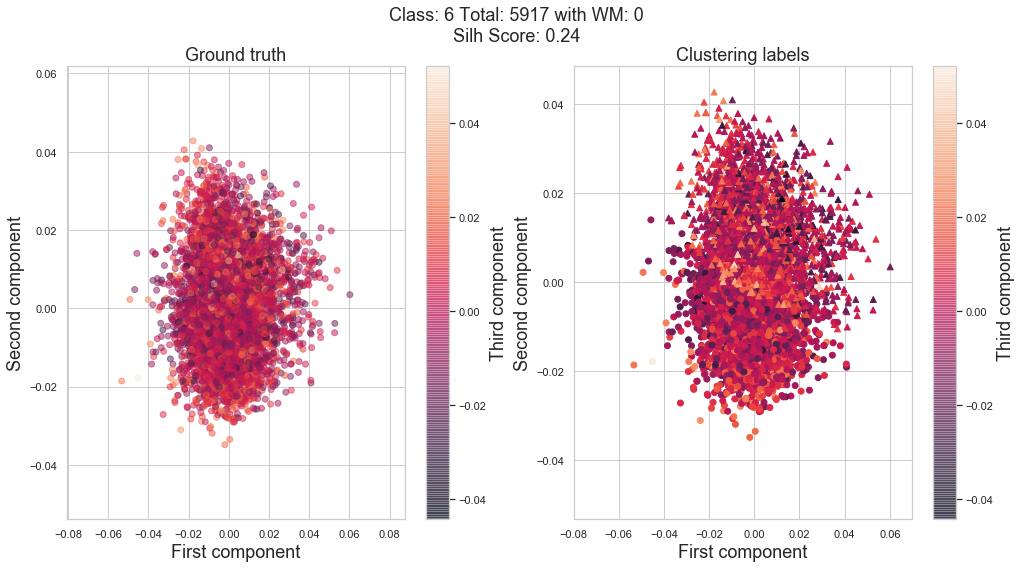

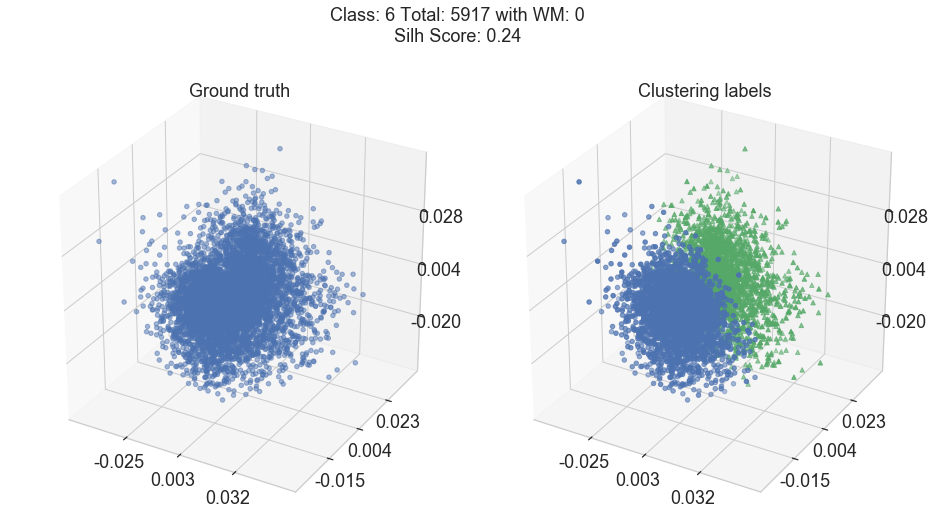

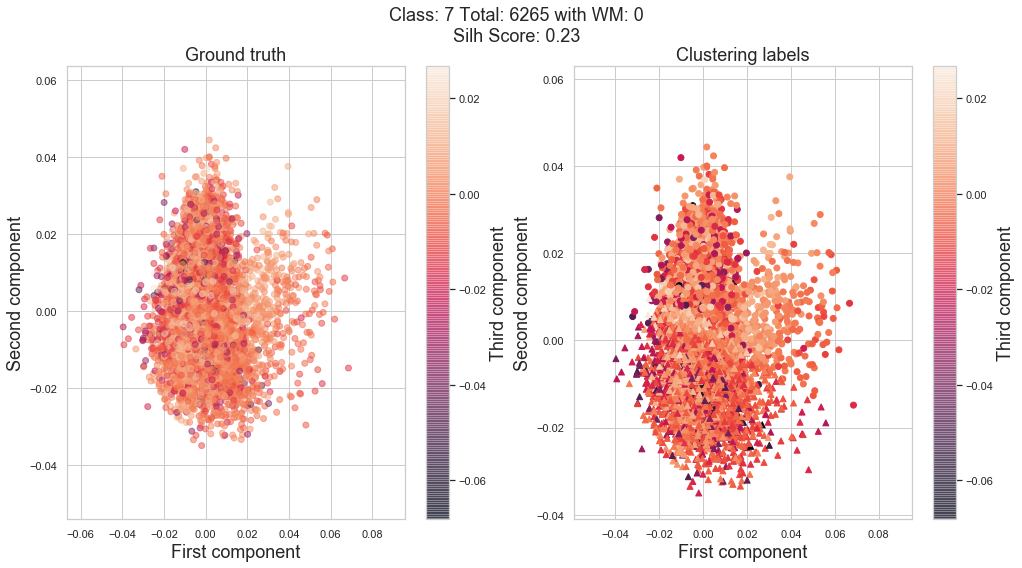

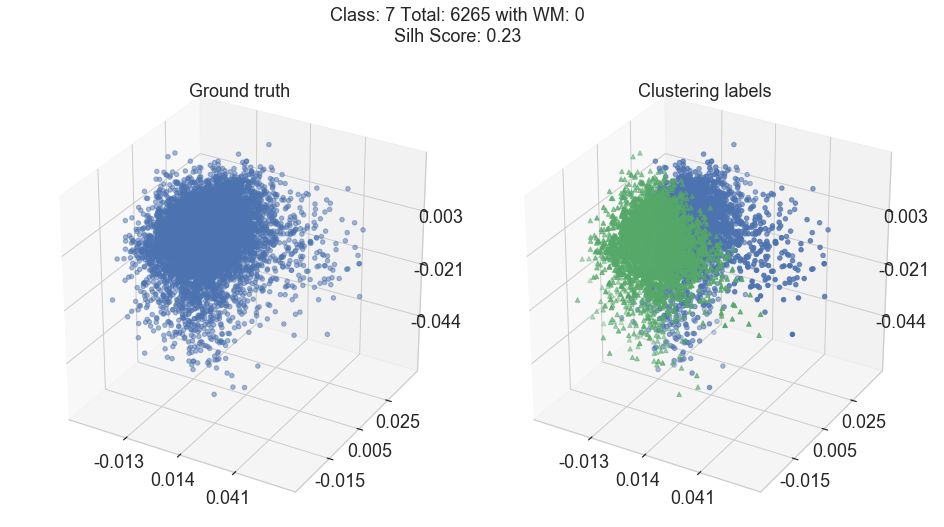

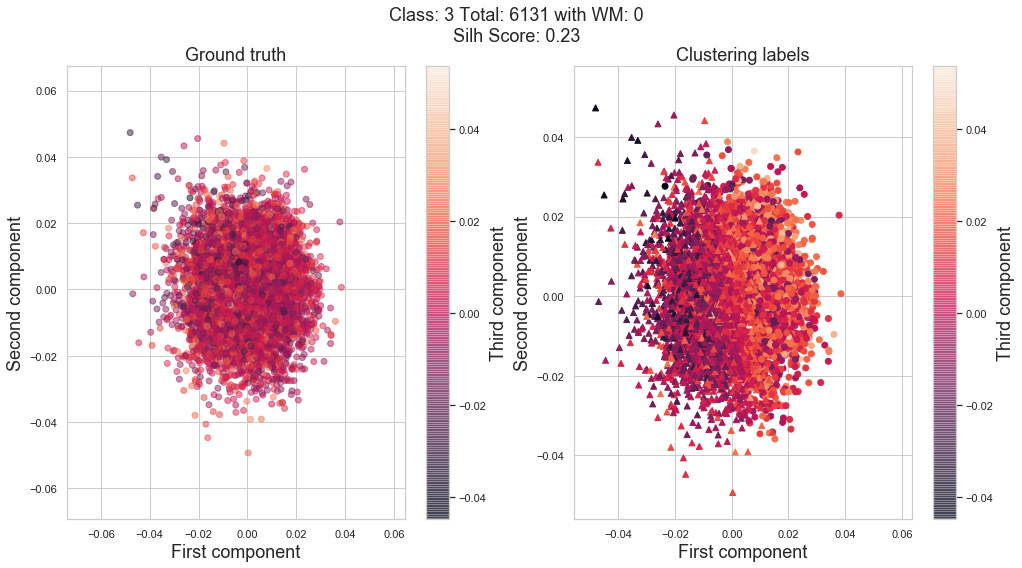

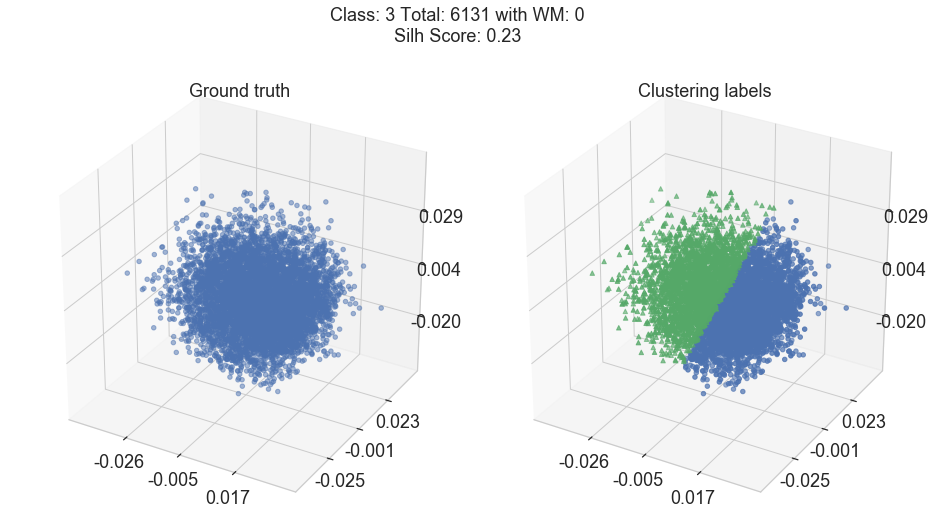

Ratio of smaller to (smaller + larger): mu = 0.4472192487081241, sigma = 0.01692533177823829
Silhouettes: mu = 0.2326119773565761, sigma = 0.0066573947543271264
Ratio of smaller in total: 0.447
Actual WM ratio: 0.004166666666666667
WM in smaller: 0
WM in larger: 0


In [12]:
analyze(legitimate_grouped, watermark_grouped=defaultdict(list))